In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install vaderSentiment

In [ ]:
pip install -U nltk

In [ ]:
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.metrics.distance import edit_distance
import re
from datetime import datetime
from datetime import date

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
from nltk import metrics

nltk.download('stopwords')

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

nlp = spacy.load('en')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Members of the intersection of both the 115th and 116th US Congress
# All of these members where there during the whole 2016-2020 period (both 115th & 116th congress)
congress = pd.read_csv("/content/drive/MyDrive/ADA/congress_115_116.csv")

In [ ]:
# Republican congressmen
congress = congress[~(congress["party"] == "ID")]
republicans = congress[congress["party"] == "R"]
print(congress['party'].value_counts())
republicans.head()

D    198
R    188
Name: party, dtype: int64


,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
0,0,H4LA05221,ralph abraham,Rep.,Abraham,Ralph,R,1954-09-16,M,LA
2,2,H6AL04098,robert aderholt,Rep.,Aderholt,Robert,R,1965-07-22,M,AL
4,4,H2GA12121,rick allen,Rep.,Allen,Rick,R,1951-11-07,M,GA
5,5,H0MI03126,justin amash,Rep.,Amash,Justin,R,1980-04-18,M,MI
6,6,H2NV02395,mark amodei,Rep.,Amodei,Mark,R,1958-06-12,M,NV


In [ ]:
# Democratic congressmen
democrats = congress[congress["party"] == "D"]
democrats.head()

,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
1,1,H4NC12100,alma adams,Rep.,Adams,Alma,D,1946-05-27,F,NC
3,3,H2CA31125,pete aguilar,Rep.,Aguilar,Pete,D,1979-06-19,M,CA
12,12,H6CA44103,nanette barragán,Rep.,Barragán,Nanette,D,1976-09-15,F,CA
13,13,H0CA33117,karen bass,Rep.,Bass,Karen,D,1953-10-03,F,CA
14,14,H2OH03125,joyce beatty,Rep.,Beatty,Joyce,D,1950-03-12,F,OH


In [ ]:
# Load data with respect to given year 
quotes_congress = []
def loadDataYear(years):
  # link to the Drive repo + the year of the newpapers quotes
  for j, year in enumerate(years_data):
    path_to_file = f'/content/drive/MyDrive/ADA/quotes-{year}-congress-speakers.json.bz2'
    # here the data is in the ADA folder placed at the root of your Drive
    with bz2.open(path_to_file, 'rb') as s_file:
        for i, sample in enumerate(s_file):
          quote = json.loads(sample)
          quotes_congress.append(quote)

In [ ]:
%%time 
#  Load data given year 
years_data = ["2016","2017","2018","2019","2020"]
loadDataYear(years_data)

CPU times: user 2min 5s, sys: 3.42 s, total: 2min 9s
Wall time: 2min 16s


In [ ]:
# Transforming the array of quotes in a pandas DataFrame
# Display dataframe
df_year_congress = pd.DataFrame(quotes_congress)
df_year_congress.head()

# Then create a new dataframe df with the political affiliation of speaker
df = df_year_congress
df['speaker'] = df['speaker'].str.lower() #puts all strings in lower cases
df_congress_new = congress[['party','speaker','date_of_birth','gender','state']].copy()
df_year_congress = df.merge(df_congress_new, how = 'left', on='speaker')
df_year_congress.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,date_of_birth,gender,state
0,2016-07-21-005544,"All the police officers that we work with, we ...",frederica wilson,[Q461504],2016-07-21 17:01:00,1,"[[Frederica Wilson, 0.8788], [None, 0.1212]]",[http://www.washingtontimes.com/news/2016/jul/...,E,D,1942-11-05,F,FL
1,2016-07-23-004668,"As a former Christian missionary, faith is cen...",tim kaine,[Q359888],2016-07-23 18:06:44,8,"[[Tim Kaine, 0.5755], [None, 0.2272], [Larry R...",[https://www.buzzfeed.com/andrewkaczynski/list...,E,D,1958-02-26,M,VA
2,2016-09-09-010924,bad bill that would put Americans' savings and...,maxine waters,[Q461727],2016-09-09 21:58:45,6,"[[Maxine Waters, 0.922], [None, 0.0728], [Jim ...",[http://thehour.com/business/article/Himes-fav...,E,D,1938-08-15,F,CA
3,2016-09-28-013218,"Better deal how? What exactly is your idea, Do...",elizabeth warren,[Q434706],2016-09-28 08:34:00,2,"[[Elizabeth Warren, 0.5615], [None, 0.3314], [...",[http://www.politico.com/story/2016/09/warren-...,E,D,1949-06-22,F,MA
4,2016-05-02-010790,"But that's the free market,",seth moulton,[Q18045052],2016-05-02 19:11:11,2,"[[Seth Moulton, 0.3773], [None, 0.2566], [Dona...",[http://gloucestertimes.com/news/local_news/mo...,E,D,1978-10-24,M,MA


In [ ]:
## take all quotations independent of party or speaker
quotations = np.array(df_year_congress["quotation"])
print(len(quotations))

1158013


In [ ]:
# HEALTH CARE
lex_field_healthcare = ["healthcare",
                        "health insurance",
                        "health maintenance",
                        "social insurance",
                        "medicare",
                        "medicaid",
                        "obamacare",
                        "affordable care act",
                        "patient protection",
                        "healthcare system",
                        "insurance coverage"
                        
                        ]

In [ ]:
# GUN POLICY
lex_field_gun_policy = ["gun policy",
                        "gun violence",
                        "gun control",
                        "gun license",
                        "gun",
                        "gunlaw"
                        "firearm",
                        "rifle",
                        "revolver",
                        "gun ownership",
                        "gun debate",
                        "gun law",
                        "firearms regulation"
                        ]

In [ ]:
# CLIMATE 
lex_field_climate = ["climate change",
"Fossil Fuel"
"Coal",
"Oil",
"Greenhouse Gas",
"Carbon Dioxide",
"Ozone",
"Global Warming",
"Greenhouse effect",
"Extreme Weather Event",
"Carbon Footprint",
"Adaptation",
"Mitigation",
"Pollutant",
"Drought" ,
"Renewable Resource",
"Climate",
"Habitat",
"Ecosystem",
"Weather",
"Precipitation",
"Global climate",
"Methane"]

In [ ]:
# IMMIGRATION
lex_field_immigration = ["Immigration",
"Immigrant",
"Immigrate",
"Influx of immigrants",
"First generation immigrant",
"Immigrant Community/Population",
"Migrant",
"Economic Migrant",
"Flood of Migrants",
"Chain Migration",
"Voluntary Migration",
"Forced migration",
"International Migration",
"Interregional Migration",
"Migration",
"Migrant Labor",
"Emigration",
"Permanent Resident",
"Temporary Resident",
"Undocumented",
"Illegal immigrant",
"Repatriation",
"Resettlement",
"Colonization", 
"Refugee", 
"Refugee Status", 
"Refugee Crisis", 
"Refugee Claimant", 
"Resettled Refugee", 
"Refugee Camp", 
"Political Refugee", 
"Economic Refugee", 
"Refugee Flow", 
"UNHCR (United Nations High Commissioner for Refugees)", 
"Internally Displaced Person", 
"Asylum", 
"An Asylum-Seeker", 
"Stateless person", 
"Humanitarian", 
"Aid", 
"Flee", 
"Terror", 
"Human rights", 
"Border", 
"Barrier",  
"Smuggling", 
"Trafficker", 
"Deportation", 
]

In [ ]:
# Select here the chosen TOPIC
lex_field = lex_field_immigration

# Lowercase conversion
lex_field = np.array([x.lower() if isinstance(x, str) else x for x in lex_field])

In [ ]:
len(quotations)

1158013

In [ ]:
# Retrieve quotes 
set_lf = set(lex_field)
lf_quotations = [quote for quote in quotations if(set_lf.intersection(set(quote.split())))]

In [ ]:
# df of quotes only on 1 subject
df_lf_quotations = pd.DataFrame(lf_quotations, index=range(len(lf_quotations)), columns = ['quotation']) 

# Retrieve all other attributes (speaker, party,...) about the quote
df_lf = df_year_congress.merge(df_lf_quotations, on=['quotation'], 
                   how='left', indicator=True)

# df containing only quotes (&attributes of the speaker) w.r.t to the subject chosen
df_lf = df_lf[df_lf['_merge'] == 'both']

# Sentiment analysis

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def getSentimentAnalysis(dataset):
  return [analyzer.polarity_scores(quote)['compound'] for quote in lf_quotations]

In [ ]:
# Retrieve sentiment scores -1 to 1
sent_quotations = getSentimentAnalysis(lf_quotations)

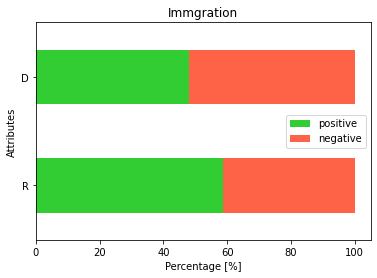

In [ ]:
# Select only positive and negative quotes (ignore neutral)
df_neg_quotes = df_lf[np.array(sent_quotations) < -0.5]
df_pos_quotes = df_lf[np.array(sent_quotations) > 0.5]

#Count the number of positive and negative quotes for EACH PARTY
df_pos_neg_party = pd.concat([df_pos_quotes.party.value_counts().to_frame('positive'), df_neg_quotes.party.value_counts().to_frame('negative')], axis=1)

#Normalize horizontal histogram
neg_data = df_pos_neg_party.apply(lambda x: x*100/sum(x),axis=1)
neg_data.plot(kind="barh", stacked = True, color = ["limegreen", "tomato"])
plt.title("Immgration")
plt.xlabel("Percentage [%]")
plt.ylabel("Attributes")
plt.savefig('/content/drive/MyDrive/ADA/immigration_nltk.png')
plt.show()